In [1]:
import numpy as np
from pylab import *

import res_utils as ru
import copy
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'text.usetex': False})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.family': 'serif', 'font.serif':['Arial']})

np.set_printoptions(precision=3)

In [2]:
noise_opts = ['input','update','codebook']

noise_type = noise_opts[2]

In [3]:
#set experiment parameters
prime_set = []
for num in range(2,101):
    for i in range(2,num):
        if (num%i==0):
            break
    else:
        prime_set.append(num)
hd_dims = np.round(2**np.arange(10,10.1,.5)).astype(int)
n_factors = [3]
kappa_facs = np.flip([1.,2.,np.nan]) #nan = noiseless

In [4]:


def update_resonator_noise(codebooks,resonator,scene,kappa):
    resonator_update = np.ones((len(codebooks),v_size),dtype=complex)
    for i in range(len(codebooks)):
        new_code = scene
        for j in range(len(codebooks)):
            if i != j:
                new_code = new_code*(resonator[j,:]**-1)
        new_code = np.dot(codebooks[i].T,np.dot(np.conj(codebooks[i]),new_code.T))    
        if not np.isnan(kb):
            noise = np.random.vonmises(0,kb,size=codebooks[m][n,:].size)
            new_code = np.exp(1j * (np.angle(new_code)+noise))

#         new_code = np.dot(outer_products[i],new_code.T)
        new_code = new_code / np.abs(new_code)
        resonator_update[i,:] = new_code
    return resonator_update

def update_resonator(codebooks,resonator,scene,kappa):
    resonator_update = np.ones((len(codebooks),v_size),dtype=complex)
    for i in range(len(codebooks)):
        new_code = scene
        for j in range(len(codebooks)):
            if i != j:
                new_code = new_code*(resonator[j,:]**-1)
        new_code = np.dot(codebooks[i].T,np.dot(np.conj(codebooks[i]),new_code.T))    
        if not np.isnan(kb):
            noise = np.random.vonmises(0,kb,size=codebooks[m][n,:].size)
            new_code = np.exp(1j * (np.angle(new_code)+noise))

#         new_code = np.dot(outer_products[i],new_code.T)
        new_code = new_code / np.abs(new_code)
        resonator_update[i,:] = new_code
    return resonator_update


def gen_res_digit(resonator,codebooks,max_iters,tree,kappa,noise=False):
    res_hist = []
    res_curr = resonator
    for i in range(max_iters):
        res_hist.append(copy.copy(res_curr))
        if noise == True:
            res_curr = update_resonator_noise(codebooks,res_curr,tree,kappa)
        else:
            res_curr = update_resonator(codebooks,res_curr,tree,kappa)
        if np.mean(np.cos(np.angle(np.ndarray.flatten(res_curr))-np.angle(np.ndarray.flatten(res_hist[-1])))) > 0.95:
            break
    res_hist.append(copy.copy(res_curr))
#         print i
    return i+1, res_hist

def dot_complex(vec1,vec2):
    num = np.dot(np.conj(vec1),vec2)
    denom = np.linalg.norm(vec1)*np.linalg.norm(vec2)
    return np.abs(num)/denom



In [7]:
n_trials = 10
restart_0 = 0 #determines index of primes to start at
skip = 1
num_iters = 100 #maximum number of iterations

acc = np.zeros((len(n_factors),len(kappa_facs),len(hd_dims),len(prime_set)-1))
acc[:] = np.nan
breaks = np.ones((len(n_factors),len(kappa_facs),len(hd_dims)))*(n_trials)
track_n_iters = np.zeros((len(n_factors),len(kappa_facs),len(hd_dims),len(prime_set)-1,n_trials))
track_n_iters[:] = np.nan
tic = time.perf_counter()

print('nf Kappa dim range acc n_iters time')

for g in range(len(n_factors)):
    nb = n_factors[g]
    restart = restart_0
    for h in range(len(kappa_facs)):
        kb = kappa_facs[h]
        for i in range(len(hd_dims)):
            v_size = hd_dims[i]
            for j in range(restart,len(prime_set)-(nb-1),skip):
                bases = prime_set[j:j+nb]

                base_size = 1
                for m in range(len(bases)):
                    base_size *= bases[m]

                acc[g,h,i,j] = 0
                for k in range(n_trials):
                    seed_vecs = []
                    for m in range(len(bases)):
                        seed_vecs.append(ru.cvecl(v_size, loopsize=bases[m]))

                    codebooks = []
                    for m in range(len(bases)):
                        samp_code = np.random.normal(0.0,1.0,size=(bases[m],v_size)) + 1j*np.random.normal(0.0,1.0,size=(bases[m],v_size))
                        samp_code = samp_code*0
                        codebooks.append(samp_code)

                    for m in range(len(bases)):
                        for n in range(bases[m]):
                            codebooks[m][n,:] = np.power(seed_vecs[m],n)
                            if noise_type=='codebook' and not np.isnan(kb):

                                noise = np.random.vonmises(0,kb,size=codebooks[m][n,:].size)
                                codebooks[m][n,:] = np.exp(1j * (np.angle(codebooks[m][n,:])+noise))

                    resonator = np.ones((len(bases),v_size),dtype=complex)
                    for m in range(len(codebooks)):
                        resonator[m,:] = np.random.normal(0.0,1.0,size=(1,v_size)) + 1j*np.random.normal(0.0,1.0,size=(1,v_size))
                        resonator[m,:] = resonator[m,:]/ np.abs(resonator[m,:])

                    samp_range = 1
                    for m in range(len(bases)):
                        samp_range *= bases[m]
                    key = np.random.randint(0,samp_range)

                    scene = np.ones((v_size,),dtype=complex)
                    for m in range(len(bases)):
                        scene *= np.power(seed_vecs[m],key)

                    if noise_type=='input' and not np.isnan(kb):
                        noise = np.random.vonmises(0,kb,size=scene.size)
                        scene = np.exp(1j * (np.angle(scene)+noise))
                        
                    if noise_type =='update':
                        n_updates, res_hist = gen_res_digit(resonator,codebooks,num_iters,scene,kb,noise=True)
                    else:
                        n_updates, res_hist = gen_res_digit(resonator,codebooks,num_iters,scene,kb,noise=False)

                    progs = []
                    for m in range(len(bases)):
                        c = codebooks[m]
                        corrs = np.zeros((n_updates+1,c.shape[0]),dtype=complex)
                        for n in range(n_updates,n_updates+1):
                            for p in range(c.shape[0]):
                                corrs[n,p] = ru.dot_complex(res_hist[n][m,:],codebooks[m][p,:])

                        progs.append(corrs)
                    is_correct = 1
                    for m in range(len(progs)):
                        is_correct *= (np.argmax(progs[m][-1,:]) == key % bases[m])
                        
                    acc[g,h,i,j] += is_correct
                    track_n_iters[g,h,i,j,k] = n_updates 
                toc = time.perf_counter()
                print(nb,kb,v_size,base_size,acc[g,h,i,j]/n_trials,np.sum(track_n_iters[g,h,i,j,:])/n_trials,toc-tic)
                tic = toc
                if(j > 3 and (acc[g,h,i,j]/n_trials) < 0.05):
                    breaks[g,h,i] = j
                    break

nf Kappa dim range acc n_iters time
3 nan 1024 30 1.0 16.7 0.05369120906107128
3 nan 1024 105 1.0 14.2 0.035927874967455864
3 nan 1024 385 1.0 16.3 0.04782900004647672
3 nan 1024 1001 1.0 26.8 0.08616491593420506
3 nan 1024 2431 1.0 18.8 0.0721341670723632
3 nan 1024 4199 1.0 17.1 0.0728214579867199
3 nan 1024 7429 1.0 25.0 0.12067804194521159
3 nan 1024 12673 1.0 17.1 0.10032500000670552
3 nan 1024 20677 1.0 20.7 0.11609795805998147
3 nan 1024 33263 1.0 23.4 0.13400433398783207
3 nan 1024 47027 1.0 27.0 0.14673941594082862
3 nan 1024 65231 1.0 27.1 0.18682970898225904
3 nan 1024 82861 1.0 27.9 0.15464483306277543
3 nan 1024 107113 1.0 40.5 0.20468770794104785
3 nan 1024 146969 0.9 57.4 0.2960930420085788
3 nan 1024 190747 0.7 77.7 0.3669052079785615
3 nan 1024 241133 0.5 92.9 0.46070575003977865
3 nan 1024 290177 0.1 97.2 0.5170076249632984
3 nan 1024 347261 0.3 82.1 0.44824004208203405
3 nan 1024 409457 0.0 100.0 0.5491607500007376
3 2.0 1024 30 1.0 100.0 0.9399365829303861
3 2.0 102

Text(0, 0.5, 'Accuracy')

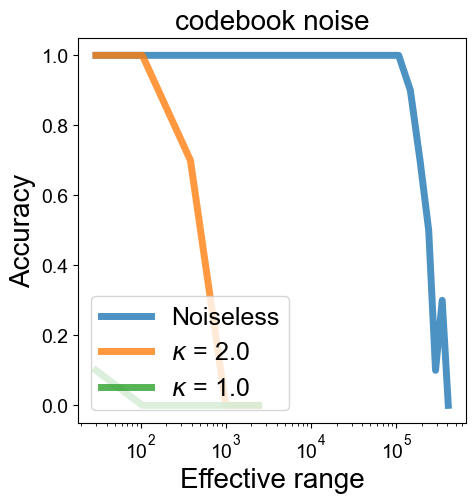

In [9]:
capacity = []
for i in range(len(n_factors)):
    cap_factor = []
    nb = n_factors[i]
    for j in range(0,len(prime_set)-(nb-1)):
        part = 1
        for k in range(nb):
            part *= prime_set[j+k]
        cap_factor.append(part)
    capacity.append(cap_factor)
figure(figsize=(5,5),dpi=100)

for i in range(len(kappa_facs)):
    idxs = np.where(np.invert(np.isnan(acc[0,i,0,:-1:2])))[0].astype('int')
    cap_temp = []
    acc_temp = []
    for j in range(len(capacity[0])):
        if not np.isnan(acc[0,i,0,j]):
            cap_temp.append(capacity[0][j])
            acc_temp.append(acc[0,i,0,j]/n_trials)

    if np.isnan(kappa_facs[i]):
        use_label = 'Noiseless'
    else:
        use_label = r'$\kappa$ = ' + str(kappa_facs[i])
    plot(cap_temp,acc_temp,'-',lw=5,alpha=.8,label=use_label)
#     plot(capacity[0],acc[0,i,0,:-1]/n_trials,'.',lw=5,alpha=.8,label='$\kappa$ = ' + str(kappa_facs[i]))

xscale('log')
legend(loc='lower left',fontsize=18)
title(str(noise_type) + ' noise',fontsize=20)
xlabel('Effective range',fontsize=20)
ylabel('Accuracy',fontsize=20)